## Dependencies

In [1]:
import pandas as pd 
from CreditScoringToolkit import frequency_table
from CreditScoringToolkit import DiscreteNormalizer
from CreditScoringToolkit import WoeEncoder
from CreditScoringToolkit import WoeContinuousFeatureSelector
from CreditScoringToolkit import WoeDiscreteFeatureSelector
from CreditScoringToolkit import CreditScoring
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.preprocessing._discretization")

## Reading data

In [3]:
data = pd.read_csv('../../data/lending_club_sample.csv',dtype=str)
# Rename variables according to provided mapping
rename_dict = {
    'loan_amnt': 'c_loan_amnt',
    'grade': 'd_grade',
    'sub_grade': 'd_sub_grade',
    'emp_length': 'd_emp_length',
    'home_ownership': 'd_home_ownership',
    'annual_inc': 'c_annual_inc',
    'purpose': 'd_purpose',
    'addr_state': 'd_addr_state',
    'dti': 'c_dti',
    'delinq_2yrs': 'c_delinq_2yrs',
    'fico_range_low': 'c_fico_range_low',
    'fico_range_high': 'c_fico_range_high',
    'inq_last_6mths': 'c_inq_last_6mths',
    'mths_since_last_delinq': 'c_mths_since_last_delinq',
    'mths_since_last_record': 'c_mths_since_last_record',
    'open_acc': 'c_open_acc',
    'pub_rec': 'c_pub_rec',
    'revol_bal': 'c_revol_bal',
    'revol_util': 'c_revol_util',
    'total_acc': 'c_total_acc',
    'application_type': 'd_application_type',
    'acc_now_delinq': 'c_acc_now_delinq',
    'tot_coll_amt': 'c_tot_coll_amt',
    'tot_cur_bal': 'c_tot_cur_bal',
    'open_acc_6m': 'c_open_acc_6m',
    'open_act_il': 'c_open_act_il',
    'open_il_12m': 'c_open_il_12m',
    'open_il_24m': 'c_open_il_24m',
    'mths_since_rcnt_il': 'c_mths_since_rcnt_il',
    'total_bal_il': 'c_total_bal_il',
    'il_util': 'c_il_util',
    'open_rv_12m': 'c_open_rv_12m',
    'open_rv_24m': 'c_open_rv_24m',
    'max_bal_bc': 'c_max_bal_bc',
    'all_util': 'c_all_util',
    'total_rev_hi_lim': 'c_total_rev_hi_lim',
    'inq_fi': 'c_inq_fi',
    'total_cu_tl': 'c_total_cu_tl',
    'inq_last_12m': 'c_inq_last_12m',
    'acc_open_past_24mths': 'c_acc_open_past_24mths',
    'avg_cur_bal': 'c_avg_cur_bal',
    'bc_open_to_buy': 'c_bc_open_to_buy',
    'bc_util': 'c_bc_util',
    'chargeoff_within_12_mths': 'c_chargeoff_within_12_mths',
    'delinq_amnt': 'c_delinq_amnt',
    'mo_sin_old_il_acct': 'c_mo_sin_old_il_acct',
    'mo_sin_old_rev_tl_op': 'c_mo_sin_old_rev_tl_op',
    'mo_sin_rcnt_rev_tl_op': 'c_mo_sin_rcnt_rev_tl_op',
    'mo_sin_rcnt_tl': 'c_mo_sin_rcnt_tl',
    'mort_acc': 'c_mort_acc',
    'mths_since_recent_bc': 'c_mths_since_recent_bc',
    'mths_since_recent_bc_dlq': 'c_mths_since_recent_bc_dlq',
    'mths_since_recent_inq': 'c_mths_since_recent_inq',
    'mths_since_recent_revol_delinq': 'c_mths_since_recent_revol_delinq',
    'num_accts_ever_120_pd': 'c_num_accts_ever_120_pd',
    'num_actv_bc_tl': 'c_num_actv_bc_tl',
    'num_actv_rev_tl': 'c_num_actv_rev_tl',
    'num_bc_sats': 'c_num_bc_sats',
    'num_bc_tl': 'c_num_bc_tl',
    'num_il_tl': 'c_num_il_tl',
    'num_op_rev_tl': 'c_num_op_rev_tl',
    'num_rev_accts': 'c_num_rev_accts',
    'num_rev_tl_bal_gt_0': 'c_num_rev_tl_bal_gt_0',
    'num_sats': 'c_num_sats',
    'num_tl_120dpd_2m': 'c_num_tl_120dpd_2m',
    'num_tl_30dpd': 'c_num_tl_30dpd',
    'num_tl_90g_dpd_24m': 'c_num_tl_90g_dpd_24m',
    'num_tl_op_past_12m': 'c_num_tl_op_past_12m',
    'pct_tl_nvr_dlq': 'c_pct_tl_nvr_dlq',
    'percent_bc_gt_75': 'c_percent_bc_gt_75',
    'pub_rec_bankruptcies': 'c_pub_rec_bankruptcies',
    'tax_liens': 'c_tax_liens',
    'tot_hi_cred_lim': 'c_tot_hi_cred_lim',
    'total_bal_ex_mort': 'c_total_bal_ex_mort',
    'total_bc_limit': 'c_total_bc_limit',
    'total_il_high_credit_limit': 'c_total_il_high_credit_limit',
    'disbursement_method': 'd_disbursement_method',
}

data.rename(columns=rename_dict, inplace=True)


data = data.loc[data['loan_status'].isin(['Fully Paid','Current','Charged Off','Late (31-120 days)'])].reset_index(drop=True)
data['target'] = 1-data['loan_status'].isin(['Fully Paid','Current'])
data.shape

(1981, 152)

## Defining feature type

In [4]:
um = ['id']
varc = [v for v in data.columns if v[:2]=='c_']
vard = [v for v in data.columns if v[:2]=='d_']
vart = ['target']
len(varc),len(vard)

(69, 8)

In [5]:
for v in varc:
    data[v] = pd.to_numeric(data[v],errors='coerce')

for v in vard:
    data[v] = data[v].fillna('MISSING')

## Data Partition 

In [6]:
train, valid  = train_test_split(data,test_size=0.3)
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)
train.shape,valid.shape

((1386, 152), (595, 152))

## Normalize Discrete Features

In [7]:
#  In this example, we aggregate categories with less than 10% of relative frequency
#  into a new category called 'SMALL CATEGORIES', if new created category don't reach
#  given relative frequency threshold (10%) then the most frequent category is imputed.
#  All missing values are treatead as the separate category MISSING

dn = DiscreteNormalizer(normalization_threshold=0.1,default_category='SMALL CATEGORIES')
dn.fit(train[vard])
Xt = dn.transform(train[vard])
frequency_table(Xt,vard)

**** Frequency Table for d_grade ****

         Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
d_grade                                                          
A               284    0.204906              284         0.204906
B               383    0.276335              667         0.481241
C               537    0.387446             1204         0.868687
D               182    0.131313             1386         1.000000




**** Frequency Table for d_sub_grade ****

                  Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
d_sub_grade                                                               
SMALL CATEGORIES        1386         1.0             1386              1.0




**** Frequency Table for d_emp_length ****

                  Abs. Freq.  Rel. Freq.  Cum. Abs. Freq.  Cum. Rel. Freq.
d_emp_length                                                              
10+ years                432    0.311688              432         0.311688
SMALL CATEGORIES    

### Check if Normalization process didn't produce unary features

In [8]:
unary = [v for v in vard if Xt[v].nunique()==1]
unary

['d_sub_grade', 'd_application_type', 'd_disbursement_method']

In [9]:
vard = [v for v in vard if v not in unary]
train.drop(unary,axis=1,inplace=True)
dn.fit(train[vard])


In [10]:
Xt = dn.transform(train[vard])

## WoE Based Best Feature Selection

In [11]:
#   Now we proceed with feature selection, we have special classes for each type of feature (discrete,continuous)
#   Discrete feature selector uses the given iv_threshold to select the best features only.
#   For continuous feature selector, a variety of methods are available for selecting the best features , namely:
#    -uniform: only uses equal-width discretized bins, selects number of bins with best IV value.  
#    -quantile: only uses equal-frequency discretized bins, selects number of bins with best IV value 
#    -kmeans: only uses discretized bins created by a K-Means clustering, selects number of bins with best IV value 
#    -gaussian: only uses discretized bins created by a Gaussian Mixture, selects number of bins with best IV value
#    -dcc: stands for Discrete Competitive Combination, creates segments for all individual methods and then 
#          selects the best method and its corresponding best number of bins for each feature.
#    -dec: stands for Discrete Exhaustive Combination, creates segments for all individual methods and then 
#          selects the best number of bins for each feature including every feasible method.
#
#   One can configure IV threshold, minimun/maximum number of discretization bins, whether or not to keep only
#   strictly monotonic segments and the number of pooling threads used in order to speed computations. 


Xt = pd.concat([Xt,train[varc]],axis=1) #Merge continuous features matrix with the normalized discrete predictors Matrix

wcf = WoeContinuousFeatureSelector()
wdf = WoeDiscreteFeatureSelector()

#  Perform feature selection
wcf.fit(Xt[varc],train['target'],
        max_bins=4,
        strictly_monotonic=True,
        iv_threshold=0.1,
        method='uniform',
        n_threads=20)

wdf.fit(Xt[vard],train['target'],iv_threshold=0.05)

#  Create new matrix with discrete and discretized best features 
Xt = pd.concat([wdf.transform(Xt[vard]),wcf.transform(Xt[varc])],axis=1)

features = list(Xt.columns)

#  Print selection results
print("Best continuous features: ", wcf.selected_features)
print("Best discrete features: ",wdf.selected_features)
print("Best Features selected: ",features)

/Users/gus/Library/Mobile Documents/com~apple~CloudDocs/trabajo_gus/anahuac/didactic-octo-telegram/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Best continuous features:  [{'feature': 'disc_c_all_util_2_uniform', 'iv': 0.12183398646256453, 'relevant': True, 'root_feature': 'c_all_util', 'nbins': '2', 'method': 'uniform', 'selected': True}, {'feature': 'disc_c_bc_util_2_uniform', 'iv': 0.11181735138490316, 'relevant': True, 'root_feature': 'c_bc_util', 'nbins': '2', 'method': 'uniform', 'selected': True}, {'feature': 'disc_c_fico_range_high_2_uniform', 'iv': 0.11015062689639009, 'relevant': True, 'root_feature': 'c_fico_range_high', 'nbins': '2', 'method': 'uniform', 'selected': True}, {'feature': 'disc_c_fico_range_low_2_uniform', 'iv': 0.11015062689639009, 'relevant': True, 'root_feature': 'c_fico_range_low', 'nbins': '2', 'method': 'uniform', 'selected': True}, {'feature': 'disc_c_inq_fi_2_uniform', 'iv': 0.12353293893172024, 'relevant': True, 'root_feature': 'c_inq_fi', 'nbins': '2', 'method': 'uniform', 'selected': True}, {'feature': 'disc_c_inq_last_12m_2_uniform', 'iv': 0.12338929004075541, 'relevant': True, 'root_featur

In [12]:
pd.crosstab(Xt['disc_c_total_cu_tl_2_uniform'],train['target']).to_clipboard()

## WoE Encoding 

In [13]:
#  Weight of Evidence Transformation
we = WoeEncoder()
we.fit(Xt[features],train['target'])
Xwt = we.transform(Xt[features])
Xwt.head()

/Users/gus/Library/Mobile Documents/com~apple~CloudDocs/trabajo_gus/anahuac/didactic-octo-telegram/.venv/lib/python3.13/site-packages/woe_credit_scoring/CreditScoringToolkit.py:550: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aux[feature] = aux[feature].replace(woe_map)


,d_grade,disc_c_all_util_2_uniform,disc_c_bc_util_2_uniform,disc_c_fico_range_high_2_uniform,disc_c_fico_range_low_2_uniform,disc_c_inq_fi_2_uniform,disc_c_inq_last_12m_2_uniform,disc_c_max_bal_bc_2_uniform,disc_c_open_acc_6m_2_uniform,disc_c_open_il_12m_2_uniform,disc_c_open_il_24m_2_uniform,disc_c_open_rv_12m_2_uniform,disc_c_open_rv_24m_2_uniform,disc_c_total_bal_il_2_uniform,disc_c_total_cu_tl_2_uniform
0,-0.371022,0.316104,0.374017,-0.076036,-0.076036,0.038989,-0.078795,0.325331,0.329344,0.344346,0.306136,0.333423,0.328008,0.313193,0.342997
1,1.166615,-0.380881,0.374017,1.461651,1.461651,-0.380881,-0.380881,-0.380881,-0.380881,-0.380881,-0.380881,-0.380881,-0.380881,-0.380881,-0.380881
2,-0.371022,-0.380881,-0.261116,-0.076036,-0.076036,-0.380881,-0.380881,-0.380881,-0.380881,-0.380881,-0.380881,-0.380881,-0.380881,-0.380881,-0.380881
3,-0.697280,0.316104,-0.261116,-0.076036,-0.076036,0.334969,0.330727,0.325331,0.329344,0.344346,0.306136,0.333423,0.328008,0.313193,0.342997
4,-0.371022,0.316104,0.374017,-0.076036,-0.076036,0.334969,0.330727,0.325331,0.329344,0.344346,0.306136,0.333423,0.328008,0.313193,0.342997


## Logistic Regression Parameter Learning

In [14]:
lr = LogisticRegression()
lr.fit(Xwt,train['target'])
print("AUC for training: ",roc_auc_score(y_score=lr.predict_proba(Xwt)[:,1],y_true=train['target']))

AUC for training:  0.7029952517046605


In [15]:
dict(zip(features,lr.coef_[0])),lr.intercept_

({'d_grade': np.float64(-0.8660971590211276),
  'disc_c_all_util_2_uniform': np.float64(0.06011084057615996),
  'disc_c_bc_util_2_uniform': np.float64(-0.47555234268860586),
  'disc_c_fico_range_high_2_uniform': np.float64(-0.21168818765735206),
  'disc_c_fico_range_low_2_uniform': np.float64(-0.21168818765735206),
  'disc_c_inq_fi_2_uniform': np.float64(0.16448620451984403),
  'disc_c_inq_last_12m_2_uniform': np.float64(0.10333173244378131),
  'disc_c_max_bal_bc_2_uniform': np.float64(0.16083292677588812),
  'disc_c_open_acc_6m_2_uniform': np.float64(0.02172174731381302),
  'disc_c_open_il_12m_2_uniform': np.float64(-0.3527886579242957),
  'disc_c_open_il_24m_2_uniform': np.float64(-0.6020910750818458),
  'disc_c_open_rv_12m_2_uniform': np.float64(-0.0359689320619312),
  'disc_c_open_rv_24m_2_uniform': np.float64(0.12446777421466122),
  'disc_c_total_bal_il_2_uniform': np.float64(-0.060482892513175374),
  'disc_c_total_cu_tl_2_uniform': np.float64(-0.5297567418085842)},
 array([-1.867

## Scoring

In [16]:
#  In order to perform the scoring transformation, we need the WoE encoded data, 
#  the WoeEncoder fitted object and the logistic regression fitter object 
#  to produce a nice formatted scorecard
cs = CreditScoring()
cs.fit(Xwt,we,lr)
cs.scorecard

points
feature                          attribute               
d_grade                          A                     52
                                 B                     37
                                 C                     13
                                 D                      5
disc_c_all_util_2_uniform        (-inf, 80.0]          22
                                 (80.0, inf]           22
                                 MISSING               23
disc_c_bc_util_2_uniform         (-inf, 53.55]         28
                                 (53.55, inf]          19
                                 MISSING               35
disc_c_fico_range_high_2_uniform (-inf, 754.0]         22
                                 (754.0, inf]          32
disc_c_fico_range_low_2_uniform  (-inf, 750.0]         22
                                 (750.0, inf]          32
disc_c_inq_fi_2_uniform          (-inf, 4.0]           21
                                 (4.0, inf]            22
                                 MISSING               24
disc_c_inq_last_12m_2_uniform    (-inf, 9.5]           22
                                 (9.5, inf]            23
                                 MISSING               24
disc_c_max_bal_bc_2_uniform      (-inf, 25170.0]       21
                                 (25170.0, inf]        22
                                 MISSING               24
disc_c_open_acc_6m_2_uniform     (-inf, 5.5]           22
                                 (5.5, inf]            23
                                 MISSING               23
disc_c_open_il_12m_2_uniform     (-inf, 3.0]           26
                                 (3.0, inf]            17
                                 MISSING               19
disc_c_open_il_24m_2_uniform     (-inf, 5.5]           28
                                 (5.5, inf]            37
                                 MISSING               16
disc_c_open_rv_12m_2_uniform     (-inf, 5.5]           23
                                 (5.5, inf]            22
                                 MISSING               22
disc_c_open_rv_24m_2_uniform     (-inf, 11.0]          21
                                 (11.0, inf]           24
                                 MISSING               24
disc_c_total_bal_il_2_uniform    (-inf, 183331.0]      23
                                 (183331.0, inf]       24
                                 MISSING               22
disc_c_total_cu_tl_2_uniform     (-inf, 10.5]          28
                                 (10.5, inf]           15
                                 MISSING               17

## Validation

### Model Generalization

In [17]:
#  Applying all transformations to the validation data is now easy and straightforward
#  we can compute AUC to check model overfitting
Xv = pd.concat([wdf.transform(dn.transform(valid[vard])),wcf.transform(valid[varc])],axis=1)
Xwv = we.transform(Xv)
print("AUC for validation: ",roc_auc_score(y_score=lr.predict_proba(Xwv)[:,1],y_true=valid['target']))

AUC for validation:  0.6519204733490448


/Users/gus/Library/Mobile Documents/com~apple~CloudDocs/trabajo_gus/anahuac/didactic-octo-telegram/.venv/lib/python3.13/site-packages/woe_credit_scoring/CreditScoringToolkit.py:550: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aux[feature] = aux[feature].replace(woe_map)


### Scoring Distributions

/Users/gus/Library/Mobile Documents/com~apple~CloudDocs/trabajo_gus/anahuac/didactic-octo-telegram/.venv/lib/python3.13/site-packages/woe_credit_scoring/CreditScoringToolkit.py:920: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aux[feature] = aux[feature].replace(points_map)
/Users/gus/Library/Mobile Documents/com~apple~CloudDocs/trabajo_gus/anahuac/didactic-octo-telegram/.venv/lib/python3.13/site-packages/woe_credit_scoring/CreditScoringToolkit.py:920: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aux[feature] = aux[feature].repl

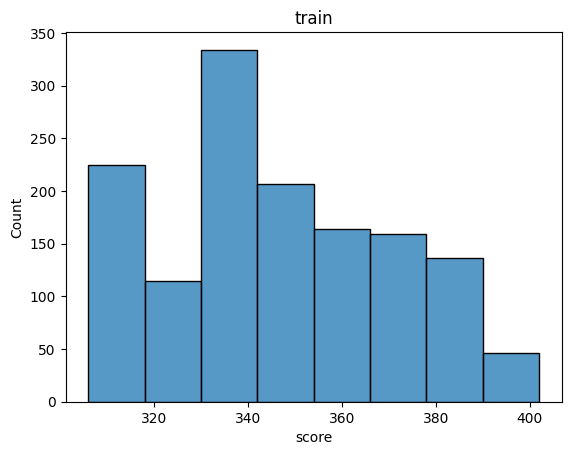

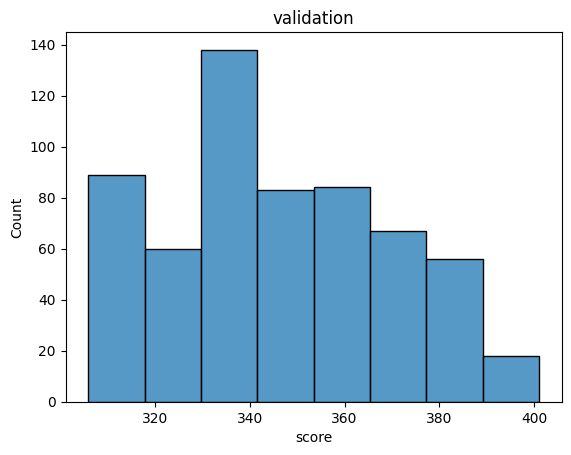

In [18]:
#  We can check the score transformation distributions for training and validation
score = pd.concat([pd.concat([cs.transform(we.inverse_transform(Xwv))[['score']].assign(sample='validation'),valid['target']],axis=1),
pd.concat([cs.transform(we.inverse_transform(Xwt))[['score']].assign(sample='train'),train['target']],axis=1)
                  ],ignore_index=True)

for s,d in score.groupby('sample'):
    plt.figure()
    plt.title(s)
    sns.histplot(d['score'],legend=True,fill=True,bins=8)

### Event rates

<Figure size 640x480 with 0 Axes>

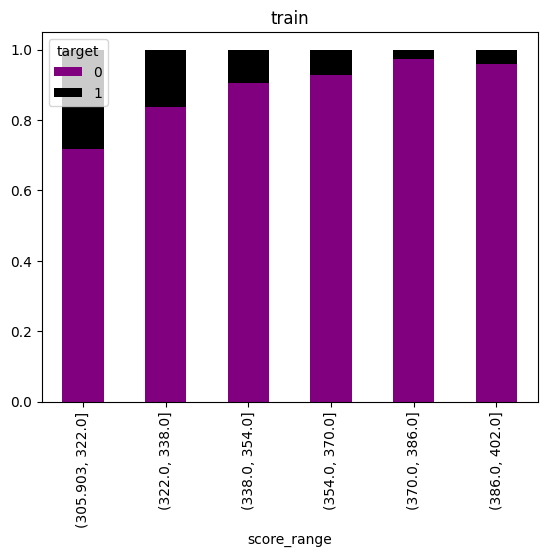

<Figure size 640x480 with 0 Axes>

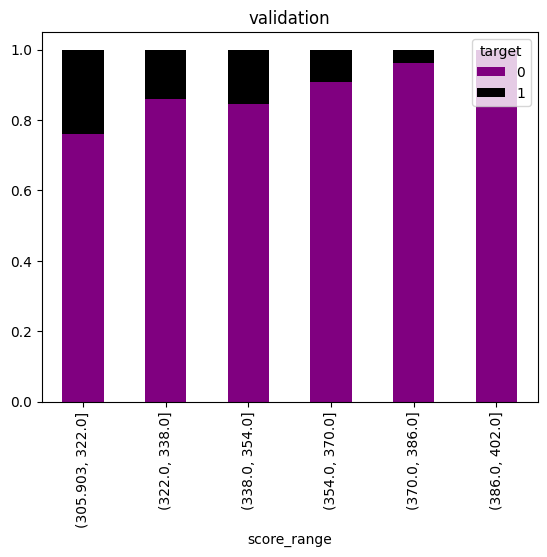

In [19]:
#   We can observe that, the greater the score, the lower the probability of being a 
#   bad customer (label=1) for both samples. Now all complexity is absorbed   
score['score_range'] = pd.cut(score['score'],bins=6,include_lowest=True).astype(str)
for s,d in score.groupby('sample'):
    aux = d.pivot_table(index='target',
                        columns='score_range',
                        values='score',
                        aggfunc='count',
                        fill_value=0)
    aux/=aux.sum()
    aux = aux.T
    plt.figure()
    ax = aux.plot(kind='bar',stacked=True,color=['purple','black'])
    plt.title(s)

In [24]:
# If you prefer, use AutoCreditScoring class to perform all the steps in a single call with additional features
# like outlier detection and treatment, feature selection, reporting and more.
from CreditScoringToolkit import AutoCreditScoring

kwargs = {'iv_feature_threshold':0.10,
          'max_discretization_bins':3,
          'strictly_monotonic':True,
          'create_reporting':True,
          'discretization_method':'uniform'}
#acs = AutoCreditScoring(train,'target',varc,vard)
#acs.fit(**kwargs)

# You can also save the reports to a folder in PNG format
#acs.save_reports('reports')


In [25]:
acs.predict(valid).head()

Exception: This AutoCreditScoring instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [ ]:
acs.credit_scoring.scorecard

points
feature                  attribute           
d_grade                  A                506
                         B                340
                         C                280
                         D                220
                         E                153
disc_c_il_util_2_uniform (-inf, 69.5]     393
                         (69.5, inf]      386
                         MISSING          246

/Users/gus/Library/Mobile Documents/com~apple~CloudDocs/trabajo_gus/anahuac/didactic-octo-telegram/.venv/lib/python3.13/site-packages/woe_credit_scoring/CreditScoringToolkit.py:550: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aux[feature] = aux[feature].replace(woe_map)
/Users/gus/Library/Mobile Documents/com~apple~CloudDocs/trabajo_gus/anahuac/didactic-octo-telegram/.venv/lib/python3.13/site-packages/woe_credit_scoring/CreditScoringToolkit.py:550: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aux[feature] = aux[feature].replace

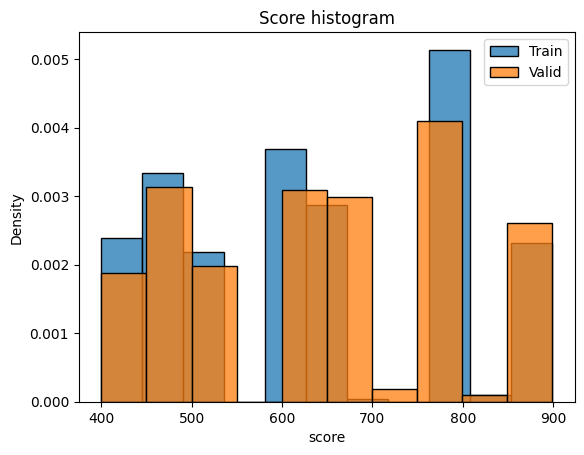

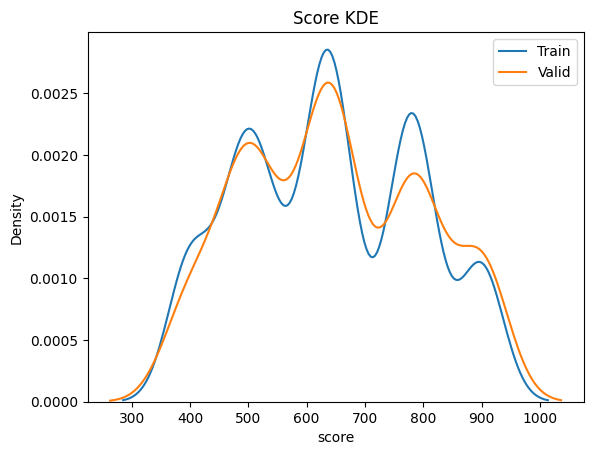

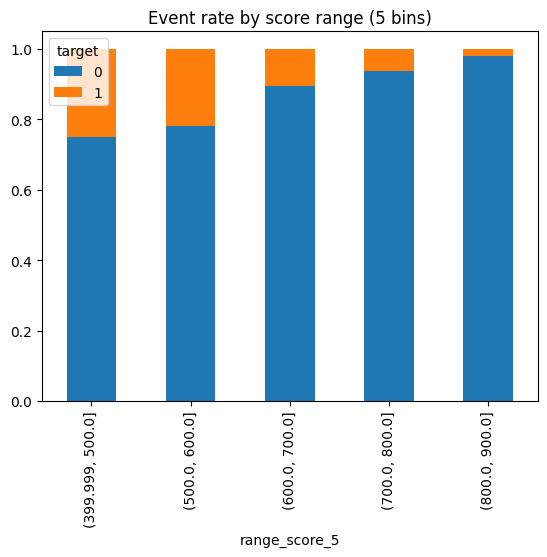

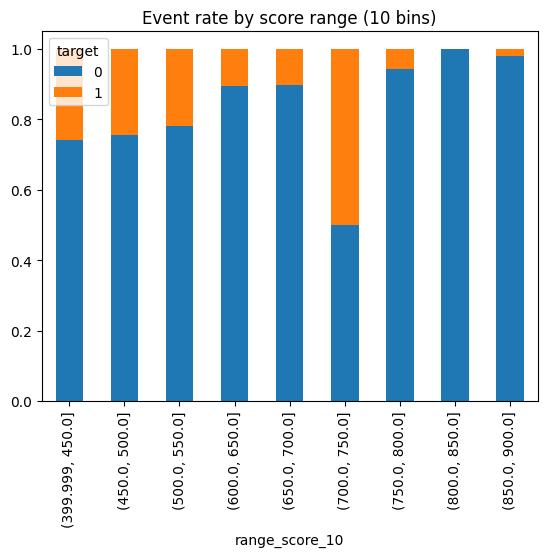

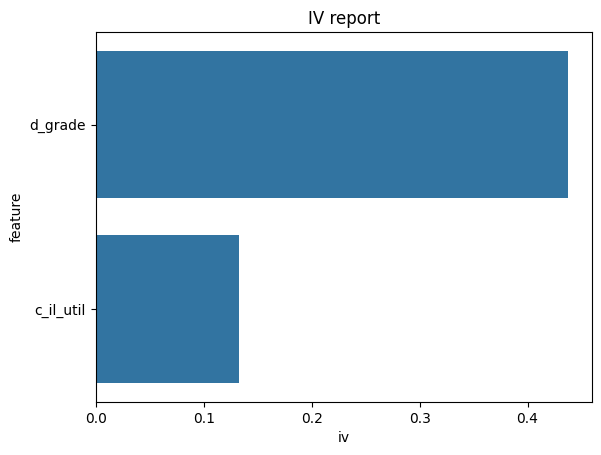

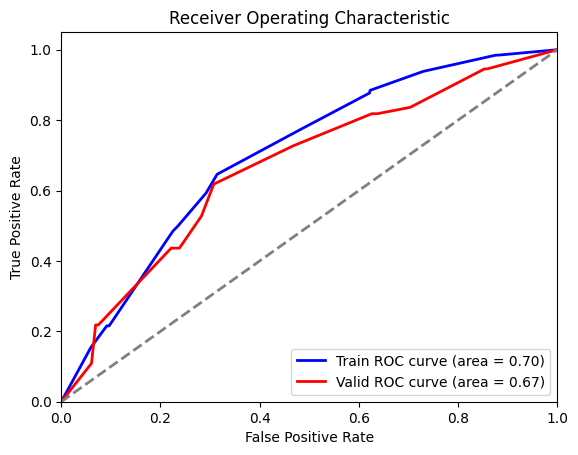

In [26]:
acs = AutoCreditScoring(train,'target',['c_il_util'],['d_grade'])
acs.fit(**kwargs)

## Persistencia del modelo 

In [27]:
import pickle 

In [ ]:
pickle.dump(acs,open('../services/lc_credit_scoring/auto_scoring_lc.pkl','wb'))

/var/folders/b2/142kycp96wdg69k6pkw9_vf00000gp/T/ipykernel_19575/492151516.py:1: DeprecationWarning: Pickle, copy, and deepcopy support will be removed from itertools in Python 3.14.
  pickle.dump(acs,open('../services/lc_credit_scoring/auto_scoring_lc.pkl','wb'))


: 